## Defining Simulator

In [1]:

import scipy.stats as stats
import scipy
import numpy as np
import matplotlib.pyplot as plt
import swyft
import torch

freq = np.arange(5.00,1024,1/4)

pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=4076, bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(5., 1024 + (1024-5)/Nbins , Nbins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-8,1e-7),
                                                stats.uniform(0,3)],
                                                bounds = bounds)

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Building Network

In [2]:
Nbins = len(freq)
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Sequential(torch.nn.Linear(Nbins, 2048),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(2048),
                                               torch.nn.Linear(2048, 512),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(512),
                                               torch.nn.Linear(512, 256),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(256),
                                               torch.nn.Linear(256, 128),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(128),
                                               torch.nn.Linear(128, 32),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(32),
                                               torch.nn.Linear(32, 8),
                                               torch.nn.ReLU(),
                                               torch.nn.BatchNorm1d(8),
                                              )
        self.summarizer = torch.nn.Linear(Nbins, 16)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features=16, num_params=2, varnames='z')
        
    def forward(self, A, B):
        s = self.summarizer(A['x'])
        logratios = self.logratios(s, B['z'])
#         logratios = self.logratios(A['x'], B['z'])
#         s = self.summarizer(A['x'])
#         s = s.unsqueeze(-1)
        return logratios #self.logratios(s, B['z']), s

100%|██████████| 100/100 [00:00<00:00, 2760.52it/s]


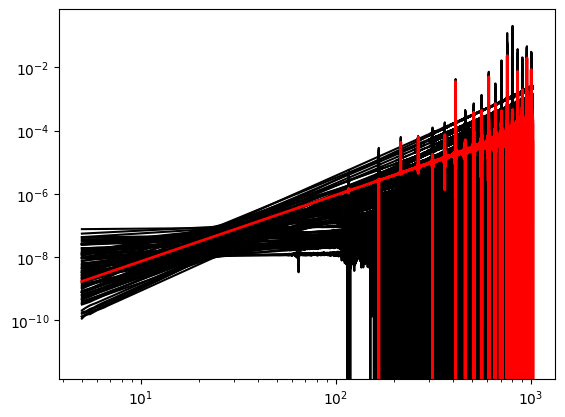

In [3]:
fref = 25
CE_PSD = np.genfromtxt("/Users/abbystokes/Documents/GitHub/DSMMA-Research/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("/Users/abbystokes/Documents/GitHub/DSMMA-Research/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(100)
for i in range(len(samples)):
    plt.loglog(sim.freq, samples[i]['x'], 'k')
plt.loglog(sim.freq, obs['x'], 'r', lw=2)

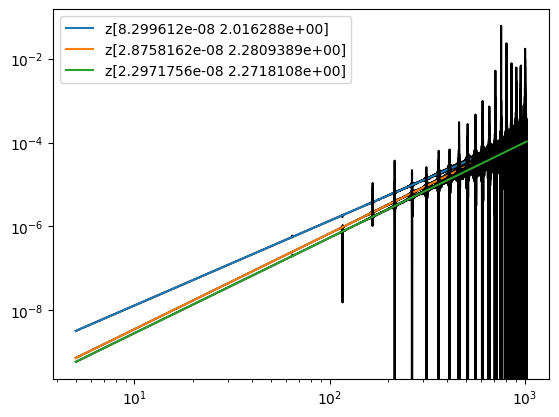

In [4]:
for i in [5, 2, 50]:
    plt.loglog(sim.freq, samples['x'][i], color='k')
    plt.loglog(sim.freq, samples['m'][i], label="z" + str(samples['z'][i]))
plt.legend()

## Fitting Data to Net

In [5]:
def round(obs, bounds=None):
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
    samples = sim.sample(20000)
    dm = swyft.SwyftDataModule(samples, batch_size=64)
    trainer = swyft.SwyftTrainer(accelerator="cpu", precision = 64)
    network = Network()
    trainer.fit(network, dm)
    prior_samples = sim.sample(N = 10000, targets=['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    new_bounds = swyft.collect_rect_bounds(predictions, 'z', (2,), threshold=1e-5)
    return predictions, new_bounds, samples

In [6]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(5):
    predictions, bounds, samples = round(obs, bounds = bounds)
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

100%|██████████| 20000/20000 [00:07<00:00, 2844.87it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of the

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: 

Epoch 6: 100%|██████████| 313/313 [00:07<00:00, 44.38it/s, loss=-0.787, v_num=4, val_loss=0.428]
Reloading best model: /Users/abbystokes/Documents/GitHub/SBI_SGWB_DSMMA/Abby/lightning_logs/version_4/checkpoints/epoch=1-step=500.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 13229.28it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0:   0%|          | 0/10 [00:00<?, ?it/s]  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 27.75it/s]
New bounds: tensor([[1.0000e-08, 9.9967e-08],
        [1.3858e+00, 2.9999e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2874.10it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 45.47it/s, loss=-1.67, v_num=5, val_loss=1.650]
Reloading best model: /Users/abbystokes/Documents/GitHub/SBI_SGWB_DSMMA/Abby/lightning_logs/version_5/checkpoints/epoch=6-step=1750.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 15596.49it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 29.87it/s]
New bounds: tensor([[1.6166e-08, 9.9966e-08],
        [1.3859e+00, 2.3896e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2980.28it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 313/313 [00:07<00:00, 44.45it/s, loss=-1.43, v_num=6, val_loss=83.90] 
Reloading best model: /Users/abbystokes/Documents/GitHub/SBI_SGWB_DSMMA/Abby/lightning_logs/version_6/checkpoints/epoch=0-step=250.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 14195.56it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 20.23it/s]
New bounds: tensor([[1.6168e-08, 9.9964e-08],
        [1.4116e+00, 2.3895e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:06<00:00, 2857.93it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 5: 100%|██████████| 313/313 [00:10<00:00, 30.77it/s, loss=-1.46, v_num=7, val_loss=3.600] 
Reloading best model: /Users/abbystokes/Documents/GitHub/SBI_SGWB_DSMMA/Abby/lightning_logs/version_7/checkpoints/epoch=0-step=250.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 11739.76it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s]
New bounds: tensor([[1.6171e-08, 9.9904e-08],
        [1.5467e+00, 2.3894e+00]], dtype=torch.float64)


100%|██████████| 20000/20000 [00:08<00:00, 2355.02it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 65.2 K
1 | logratios  | LogRatioEstimator_1dim | 36.7 K
------------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.816     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 313/313 [00:07<00:00, 42.67it/s, loss=-1.76, v_num=8, val_loss=2.410]
Reloading best model: /Users/abbystokes/Documents/GitHub/SBI_SGWB_DSMMA/Abby/lightning_logs/version_8/checkpoints/epoch=14-step=3750.ckpt


100%|██████████| 10000/10000 [00:00<00:00, 15034.88it/s]
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 28.07it/s]
New bounds: tensor([[3.5589e-08, 9.0860e-08],
        [1.8670e+00, 2.2745e+00]], dtype=torch.float64)


## Visualize Posterior Parameters

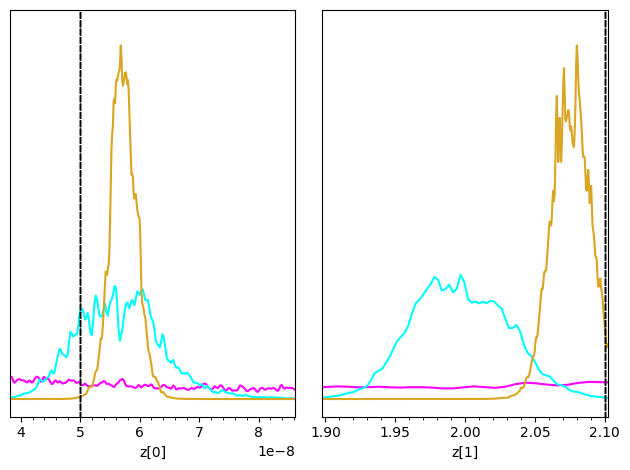

In [ ]:
# without batch normalization

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

plt.title('Regular Linear Layers')

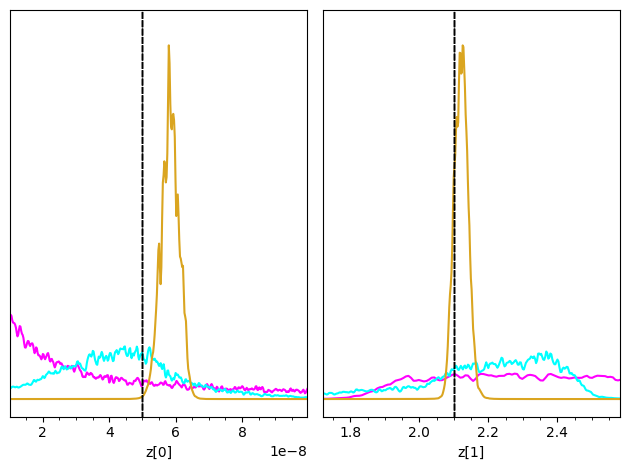

In [ ]:
# with batch normalization
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

plt.title('Batch Normalization')

Text(0.5, 1.0, 'Regular Linear Layers')

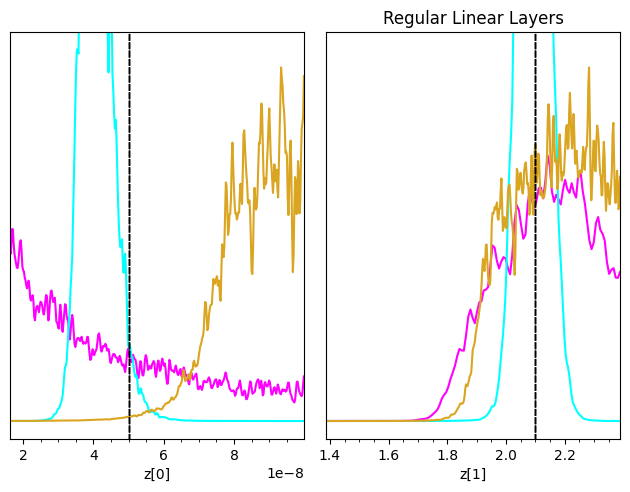

In [7]:
# with batch normalization, lower prior truncation threshold (1e-5)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

plt.title('Regular Linear Layers')

In [ ]:
# with batch normalization, drop-out lower prior truncation threshold (1e-5)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(3):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

plt.title('Regular Linear Layers')